# Installs & Imports

In [1]:
!pip install -q rpy2 sktime dask[dataframe]

In [2]:
import numpy as np
import pandas as pd
from pandas.tseries.offsets import Week
import matplotlib.pyplot as plt
import seaborn as sns
import math

import os
import io
from IPython.display import Image, display, HTML
import contextlib
import warnings

import rpy2.robjects as ro
from rpy2.robjects.packages import importr, PackageNotInstalledError
from rpy2.robjects import r, pandas2ri, DataFrame
from rpy2.robjects import StrVector, FloatVector
from rpy2.robjects.conversion import localconverter
import rpy2.robjects.lib.grdevices as grdevices
import rpy2.ipython.html
from rpy2.rinterface_lib.sexp import NULLType

from sklearn.feature_selection import VarianceThreshold
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
import sktime
from sktime.forecasting.compose import make_reduction
from sktime.split import temporal_train_test_split
from sktime.transformations.series.date import DateTimeFeatures
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.compose import ForecastingPipeline
from sktime.transformations.series.summarize import WindowSummarizer
from sktime.datatypes import mtype, convert_to
from sktime.performance_metrics.forecasting import (
    mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error,
    mean_absolute_scaled_error,
    make_forecasting_scorer
)
import xgboost as xgb

warnings.filterwarnings("ignore", category=FutureWarning)
pd.options.mode.chained_assignment = None
# pd.set_option("display.max_columns", None)
# pd.set_option('display.max_rows', None)

# RPy2 Setup

In [3]:
# Enable R printing
rpy2.ipython.html.init_printing()

# Enable automatic DataFrame conversion
pandas2ri.activate()

In [4]:
def manage_r_packages(packages):
    """
    Installs missing R packages and imports them into Python.

    Parameters:
    packages (list): List of R package names to check, install, and import.

    Returns:
    dict: Dictionary of imported R packages.
    """
    missing_packages = []
    installed_packages = {}

    # Check which packages are already installed and install missing ones
    for package_name in packages:
        try:
            installed_packages[package_name] = importr(package_name)
            print(f"{package_name} is already installed and imported.")
        except PackageNotInstalledError:
            missing_packages.append(package_name)

    # If there are missing packages, install them
    if missing_packages:
        print(f"Installing missing packages: {missing_packages}")
        utils = importr('utils')
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            with contextlib.redirect_stdout(None):
                utils.install_packages(StrVector(missing_packages), quiet=True)

        # Import newly installed packages
        for package_name in missing_packages:
            try:
                installed_packages[package_name] = importr(package_name)
                print(f"Successfully installed and imported {package_name}.")
            except Exception as e:
                print(f"Failed to import {package_name} after installation: {str(e)}")
    else:
        print("All required packages are already installed and imported.")

    return installed_packages

In [5]:
# List of required R packages
required_packages = ['forecast', 'ggplot2', 'tidymodels', 'modeltime', 'timetk', 'tidyverse']

# Install and import required R packages
importr('base')
importr('utils')
r_packages = manage_r_packages(required_packages)

forecast is already installed and imported.
ggplot2 is already installed and imported.
tidymodels is already installed and imported.
modeltime is already installed and imported.
timetk is already installed and imported.
tidyverse is already installed and imported.
All required packages are already installed and imported.


In [6]:
def run_r_script(r_code, dataframe=None):
    """
    Executes the provided R code string, optionally passing a Pandas DataFrame into the R environment.
    Returns the list of R objects.

    Parameters:
    r_code (str): The R code to be executed in string form.
    dataframe (pd.DataFrame, optional): The user's input DataFrame to be passed to R. Default is None.

    Returns:
    list: The list of R objects returned by the R code.
    """
    # If a DataFrame is provided, convert it to an R DataFrame and pass to the global environment
    if dataframe is not None:
        r_df = ro.DataFrame(dataframe)
        ro.globalenv['input_df'] = r_df

    # Run the provided R script
    results = r(r_code)

    return results

In [7]:
# Create an output directory
output_dir = "/content/output_plots"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print(f"Output plots will be saved to: {output_dir}")

Output plots will be saved to: /content/output_plots


# Data Loading

In [8]:
# R script
r_code = """
# Load the data
data_table <- walmart_sales_weekly %>%
    select(id, date = Date, value = Weekly_Sales)

print("Data Table:")
print(data_table)
cat("\n")

# Convert to DataFrame
data_df <- as.data.frame(data_table)

print("DataFrame:")
print(head(data_df))

# Save the subsequent plot as a PNG file
png('/content/output_plots/walmart_sales_plot.png', width=800, height=600)

walmart_sales_plot <- data_table %>%
    group_by(id) %>%
    plot_time_series(
        date, value, .interactive = F, .facet_ncol = 2
    )

plot(walmart_sales_plot)

# Close the PNG device
dev.off()

# Return the data
list(data_table = data_table, data_df = data_df)
"""

In [9]:
# Run the R script
results = run_r_script(r_code)

# Extract the data returned from R
data_table_r = results[0]
data_df_r = results[1]

[1] "Data Table:"
# A tibble: 1,001 × 3
   id    date        value
   <fct> <date>      <dbl>
 1 1_1   2010-02-05 24924.
 2 1_1   2010-02-12 46039.
 3 1_1   2010-02-19 41596.
 4 1_1   2010-02-26 19404.
 5 1_1   2010-03-05 21828.
 6 1_1   2010-03-12 21043.
 7 1_1   2010-03-19 22137.
 8 1_1   2010-03-26 26229.
 9 1_1   2010-04-02 57258.
10 1_1   2010-04-09 42961.
# ℹ 991 more rows
# ℹ Use `print(n = ...)` to see more rows

[1] "DataFrame:"
   id       date    value
1 1_1 2010-02-05 24924.50
2 1_1 2010-02-12 46039.49
3 1_1 2010-02-19 41595.55
4 1_1 2010-02-26 19403.54
5 1_1 2010-03-05 21827.90
6 1_1 2010-03-12 21043.39


In [10]:
# Display the data in Python
print("Data Table from R:")
display(data_table_r)

print("\nDataFrame from R:")
display(data_df_r.head())

Data Table from R:


,id,date,value
1,1_1,14645.0,24924.50
2,1_1,14652.0,46039.49
3,1_1,14659.0,41595.55
4,1_1,14666.0,19403.54
5,1_1,14673.0,21827.90
...,...,...,...
997,1_95,15611.0,115326.47
998,1_95,15618.0,127009.22
999,1_95,15625.0,124559.93
1000,1_95,15632.0,123346.24



DataFrame from R:


,id,date,value
1,1_1,14645.0,24924.50
2,1_1,14652.0,46039.49
3,1_1,14659.0,41595.55
4,1_1,14666.0,19403.54
5,1_1,14673.0,21827.90


In [11]:
# Correct the 'date' column
data_df_r['date'] = pd.to_datetime(data_df_r['date'], unit='D', origin='1970-01-01')
print("Corrected DataFrame from R:")
display(data_df_r.head(10))

Corrected DataFrame from R:


,id,date,value
1,1_1,2010-02-05,24924.50
2,1_1,2010-02-12,46039.49
3,1_1,2010-02-19,41595.55
4,1_1,2010-02-26,19403.54
5,1_1,2010-03-05,21827.90
6,1_1,2010-03-12,21043.39
7,1_1,2010-03-19,22136.64
8,1_1,2010-03-26,26229.21
9,1_1,2010-04-02,57258.43
10,1_1,2010-04-09,42960.91


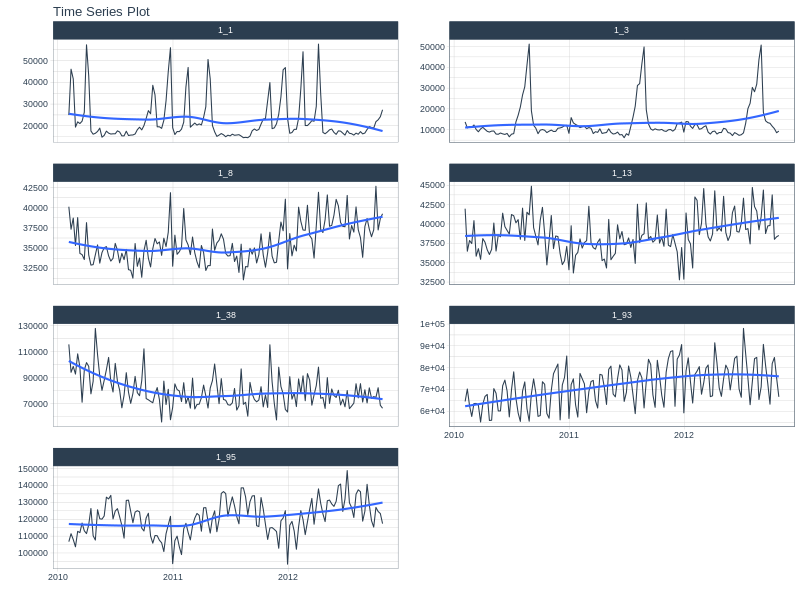

In [12]:
# Display the saved PNG plot in the notebook
walmart_sales_plot = os.path.join(output_dir, "walmart_sales_plot.png")
display(Image(filename=walmart_sales_plot))

# Data Preparation

## R

In [13]:
# R script
r_code = """
# Split the data
splits <- data_table %>%
    time_series_split(
        assess = "3 months",
        cumulative = TRUE
    )

splits_df <- as.data.frame(splits)

train_split <- training(splits)
train_split_df <- as.data.frame(train_split)
print("Train Split:")
print(train_split)
cat("\n")

test_split <- testing(splits)
test_split_df <- as.data.frame(test_split)
print("Test Split:")
print(test_split)
cat("\n")

# Preprocess the data
recipe_object <- recipe(value ~ ., training(splits)) %>%
    step_mutate_at(id, fn = droplevels) %>%
    step_timeseries_signature(date) %>%
    step_rm(date) %>%
    step_zv(all_predictors()) %>%
    step_dummy(all_nominal_predictors(), one_hot = TRUE)

print("Recipe:")
print(recipe_object)
cat("\n")

summary_object <- summary(prep(recipe_object))
print("Summary:")
print(summary_object, n = 38)

# Return objects
list(
    splits = splits,
    splits_df = splits_df,
    train_split = train_split,
    train_split_df = train_split_df,
    test_split = test_split,
    test_split_df = test_split_df,
    recipe_object = recipe_object
)
"""

In [14]:
# Run the R script
results = run_r_script(r_code)

# Extract the data returned from R
splits_r = results[0]
splits_df_r = results[1]
train_split_r = results[2]
train_split_df_r = results[3]
test_split_r = results[4]
test_split_df_r = results[5]
recipe_object_r = results[6]

[1] "Train Split:"
# A tibble: 917 × 3
   id    date         value
   <fct> <date>       <dbl>
 1 1_1   2010-02-05  24924.
 2 1_3   2010-02-05  13740.
 3 1_8   2010-02-05  40129.
 4 1_13  2010-02-05  41969.
 5 1_38  2010-02-05 115564.
 6 1_93  2010-02-05  64495.
 7 1_95  2010-02-05 106690.
 8 1_1   2010-02-12  46039.
 9 1_3   2010-02-12  10888.
10 1_8   2010-02-12  37335.
# ℹ 907 more rows
# ℹ Use `print(n = ...)` to see more rows

[1] "Test Split:"
# A tibble: 84 × 3
   id    date         value
   <fct> <date>       <dbl>
 1 1_1   2012-08-10  16120.
 2 1_3   2012-08-10  28257.
 3 1_8   2012-08-10  37270.
 4 1_13  2012-08-10  42241.
 5 1_38  2012-08-10  74483.
 6 1_93  2012-08-10  84119.
 7 1_95  2012-08-10 137408.
 8 1_1   2012-08-17  17331.
 9 1_3   2012-08-17  31906.
10 1_8   2012-08-17  36294.
# ℹ 74 more rows
# ℹ Use `print(n = ...)` to see more rows

[1] "Recipe:"

── Recipe ──────────────────────────────────────────────────────────────────────

── Inputs 
Number of variables by 

## Python

In [15]:
# Display the data in Python
print("Training Data from R:")
train_split_df_r['date'] = pd.to_datetime(train_split_df_r['date'], unit='D', origin='1970-01-01')
display(train_split_df_r.head())
print("\nTest Data from R:")
test_split_df_r['date'] = pd.to_datetime(test_split_df_r['date'], unit='D', origin='1970-01-01')
display(test_split_df_r.head())

Training Data from R:


,id,date,value
1,1_1,2010-02-05,24924.50
2,1_3,2010-02-05,13740.12
3,1_8,2010-02-05,40129.01
4,1_13,2010-02-05,41969.29
5,1_38,2010-02-05,115564.35



Test Data from R:


,id,date,value
1,1_1,2012-08-10,16119.92
2,1_3,2012-08-10,28257.30
3,1_8,2012-08-10,37269.92
4,1_13,2012-08-10,42241.23
5,1_38,2012-08-10,74483.32


In [16]:
# Shape of training data
print("Shape of Training Data:")
print(train_split_df_r.shape)

# Shape of test data
print("\nShape of Test Data:")
print(test_split_df_r.shape)

Shape of Training Data:
(917, 3)

Shape of Test Data:
(84, 3)


In [17]:
# Ensure 'id' is of type 'category'
train_split_df_r['id'] = train_split_df_r['id'].astype('category')
test_split_df_r['id'] = test_split_df_r['id'].astype('category')

In [18]:
# Remove unused categories in training data
train_split_df_r['id'] = train_split_df_r['id'].cat.remove_unused_categories()

# Align test data categories with training data
test_split_df_r['id'] = test_split_df_r['id'].cat.set_categories(train_split_df_r['id'].cat.categories)

In [19]:
# Number of unique 'id'
print("Number of Unique 'id' in Training Data:")
unique_ids_train = train_split_df_r['id'].nunique()
print(unique_ids_train)

print("\nNumber of Unique 'id' in Test Data:")
unique_ids_test = test_split_df_r['id'].nunique()
print(unique_ids_test)

Number of Unique 'id' in Training Data:
7

Number of Unique 'id' in Test Data:
7


In [20]:
# IDs in the training set
print("IDs in the Training Set:")
for id in train_split_df_r['id'].unique():
    print(f"ID: {id}")

# IDs in the test set
print("\nIDs in the Test Set:")
for id in test_split_df_r['id'].unique():
    print(f"ID: {id}")

IDs in the Training Set:
ID: 1_1
ID: 1_3
ID: 1_8
ID: 1_13
ID: 1_38
ID: 1_93
ID: 1_95

IDs in the Test Set:
ID: 1_1
ID: 1_3
ID: 1_8
ID: 1_13
ID: 1_38
ID: 1_93
ID: 1_95


In [21]:
# Function to create datetime features
def create_datetime_features(df, date_col='date'):
    df = df.copy()
    df['year'] = df[date_col].dt.year
    df['month'] = df[date_col].dt.month
    df['day'] = df[date_col].dt.day
    df['day_of_week'] = df[date_col].dt.dayofweek
    df['week_of_year'] = df[date_col].dt.isocalendar().week.astype(int)
    df['quarter'] = df[date_col].dt.quarter
    df['is_month_start'] = df[date_col].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_col].dt.is_month_end.astype(int)
    df['is_quarter_start'] = df[date_col].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_col].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_col].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_col].dt.is_year_end.astype(int)
    return df

# Apply to training and testing data
train_split_df_r = create_datetime_features(train_split_df_r, 'date')
test_split_df_r = create_datetime_features(test_split_df_r, 'date')

# Display the data
print("Training Data:")
display(train_split_df_r.head())
print("\nTest Data:")
display(test_split_df_r.head())

Training Data:


,id,date,value,year,month,day,day_of_week,week_of_year,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
1,1_1,2010-02-05,24924.50,2010,2,5,4,5,1,0,0,0,0,0,0
2,1_3,2010-02-05,13740.12,2010,2,5,4,5,1,0,0,0,0,0,0
3,1_8,2010-02-05,40129.01,2010,2,5,4,5,1,0,0,0,0,0,0
4,1_13,2010-02-05,41969.29,2010,2,5,4,5,1,0,0,0,0,0,0
5,1_38,2010-02-05,115564.35,2010,2,5,4,5,1,0,0,0,0,0,0



Test Data:


,id,date,value,year,month,day,day_of_week,week_of_year,quarter,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end
1,1_1,2012-08-10,16119.92,2012,8,10,4,32,3,0,0,0,0,0,0
2,1_3,2012-08-10,28257.30,2012,8,10,4,32,3,0,0,0,0,0,0
3,1_8,2012-08-10,37269.92,2012,8,10,4,32,3,0,0,0,0,0,0
4,1_13,2012-08-10,42241.23,2012,8,10,4,32,3,0,0,0,0,0,0
5,1_38,2012-08-10,74483.32,2012,8,10,4,32,3,0,0,0,0,0,0


In [22]:
# Get info
train_split_df_r.info()

<class 'pandas.core.frame.DataFrame'>
Index: 917 entries, 1 to 917
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                917 non-null    category      
 1   date              917 non-null    datetime64[ns]
 2   value             917 non-null    float64       
 3   year              917 non-null    int32         
 4   month             917 non-null    int32         
 5   day               917 non-null    int32         
 6   day_of_week       917 non-null    int32         
 7   week_of_year      917 non-null    int64         
 8   quarter           917 non-null    int32         
 9   is_month_start    917 non-null    int64         
 10  is_month_end      917 non-null    int64         
 11  is_quarter_start  917 non-null    int64         
 12  is_quarter_end    917 non-null    int64         
 13  is_year_start     917 non-null    int64         
 14  is_year_end       917 non-null 

In [23]:
# Sort by 'id' and 'date' to ensure proper ordering
train_split_df_r = train_split_df_r.sort_values(['id', 'date'])
test_split_df_r = test_split_df_r.sort_values(['id', 'date'])

# Convert to pandas MultiIndex
train_split_df_r.set_index(['id', 'date'], inplace=True)
test_split_df_r.set_index(['id', 'date'], inplace=True)

print("Training Data:")
display(train_split_df_r.head())
print("\nTest Data:")
display(test_split_df_r.head())

Training Data:


value  year  month  day  day_of_week  week_of_year  \
id  date                                                                
1_1 2010-02-05  24924.50  2010      2    5            4             5   
    2010-02-12  46039.49  2010      2   12            4             6   
    2010-02-19  41595.55  2010      2   19            4             7   
    2010-02-26  19403.54  2010      2   26            4             8   
    2010-03-05  21827.90  2010      3    5            4             9   

                quarter  is_month_start  is_month_end  is_quarter_start  \
id  date                                                                  
1_1 2010-02-05        1               0             0                 0   
    2010-02-12        1               0             0                 0   
    2010-02-19        1               0             0                 0   
    2010-02-26        1               0             0                 0   
    2010-03-05        1               0             0                 0   

                is_quarter_end  is_year_start  is_year_end  
id  date                                                    
1_1 2010-02-05               0              0            0  
    2010-02-12               0              0            0  
    2010-02-19               0              0            0  
    2010-02-26               0              0            0  
    2010-03-05               0              0            0


Test Data:


value  year  month  day  day_of_week  week_of_year  \
id  date                                                                
1_1 2012-08-10  16119.92  2012      8   10            4            32   
    2012-08-17  17330.70  2012      8   17            4            33   
    2012-08-24  16286.40  2012      8   24            4            34   
    2012-08-31  16680.24  2012      8   31            4            35   
    2012-09-07  18322.37  2012      9    7            4            36   

                quarter  is_month_start  is_month_end  is_quarter_start  \
id  date                                                                  
1_1 2012-08-10        3               0             0                 0   
    2012-08-17        3               0             0                 0   
    2012-08-24        3               0             0                 0   
    2012-08-31        3               0             1                 0   
    2012-09-07        3               0             0                 0   

                is_quarter_end  is_year_start  is_year_end  
id  date                                                    
1_1 2012-08-10               0              0            0  
    2012-08-17               0              0            0  
    2012-08-24               0              0            0  
    2012-08-31               0              0            0  
    2012-09-07               0              0            0

In [24]:
# Initialize VarianceThreshold to remove features with zero variance
initial_columns = train_split_df_r.columns.tolist()
selector = VarianceThreshold(threshold=0.0)

# Fit on training data (excluding target)
selector.fit(train_split_df_r.drop('value', axis=1))

# Get mask of features to keep
features_to_keep = train_split_df_r.drop('value', axis=1).columns[selector.get_support()]

# Apply to training and test data
train_split_df_r = train_split_df_r[features_to_keep.tolist() + ['value']]
test_split_df_r = test_split_df_r[features_to_keep.tolist() + ['value']]

print("Removed columns with zero variance:")
removed_columns = set(initial_columns) - set(features_to_keep.tolist() + ['value'])
print(removed_columns)

Removed columns with zero variance:
{'day_of_week', 'is_year_start'}


In [25]:
# # Identify columns with the same value in all rows
# constant_columns = [col for col in train_split_df_r.columns if train_split_df_r[col].nunique() <= 1 and col != 'value']

# # Drop them
# train_split_df_r.drop(columns=constant_columns, inplace=True)
# test_split_df_r.drop(columns=constant_columns, inplace=True)

# print("Removed constant columns:", constant_columns)

In [26]:
# Convert datetime features to categorical dtypes
categorical_features = ['year', 'month', 'day', 'week_of_year', 'quarter']

for col in categorical_features:
    train_split_df_r[col] = train_split_df_r[col].astype('category')
    test_split_df_r[col] = test_split_df_r[col].astype('category')

In [27]:
# Identify categorical columns
categorical_cols = train_split_df_r.select_dtypes(include=['category', 'object']).columns.tolist()
print("Categorical Columns Identified for Encoding:", categorical_cols)

Categorical Columns Identified for Encoding: ['year', 'month', 'day', 'week_of_year', 'quarter']


In [28]:
# One-hot encode categorical columns in training data
train_split_df_r = pd.get_dummies(train_split_df_r, columns=categorical_cols, drop_first=False)

# One-hot encode categorical columns in test data
test_split_df_r = pd.get_dummies(test_split_df_r, columns=categorical_cols, drop_first=False)

# Align the train and test data to have the same columns
train_split_df_r, test_split_df_r = train_split_df_r.align(test_split_df_r, join='left', axis=1, fill_value=0)

print("Columns after one-hot encoding:")
print(train_split_df_r.columns)

Columns after one-hot encoding:
Index(['is_month_start', 'is_month_end', 'is_quarter_start', 'is_quarter_end',
       'is_year_end', 'value', 'year_2010', 'year_2011', 'year_2012',
       'month_1',
       ...
       'week_of_year_47', 'week_of_year_48', 'week_of_year_49',
       'week_of_year_50', 'week_of_year_51', 'week_of_year_52', 'quarter_1',
       'quarter_2', 'quarter_3', 'quarter_4'],
      dtype='object', length=108)


In [29]:
# Convert features to numeric for XGBoost
non_target_features = train_split_df_r.drop('value', axis=1).columns

for col in non_target_features:
    train_split_df_r[col] = train_split_df_r[col].astype(int)
    test_split_df_r[col] = test_split_df_r[col].astype(int)

print("Data after conversion:")
display(train_split_df_r.head())

Data after conversion:


is_month_start  is_month_end  is_quarter_start  \
id  date                                                         
1_1 2010-02-05               0             0                 0   
    2010-02-12               0             0                 0   
    2010-02-19               0             0                 0   
    2010-02-26               0             0                 0   
    2010-03-05               0             0                 0   

                is_quarter_end  is_year_end     value  year_2010  year_2011  \
id  date                                                                      
1_1 2010-02-05               0            0  24924.50          1          0   
    2010-02-12               0            0  46039.49          1          0   
    2010-02-19               0            0  41595.55          1          0   
    2010-02-26               0            0  19403.54          1          0   
    2010-03-05               0            0  21827.90          1          0   

                year_2012  month_1  ...  week_of_year_47  week_of_year_48  \
id  date                            ...                                     
1_1 2010-02-05          0        0  ...                0                0   
    2010-02-12          0        0  ...                0                0   
    2010-02-19          0        0  ...                0                0   
    2010-02-26          0        0  ...                0                0   
    2010-03-05          0        0  ...                0                0   

                week_of_year_49  week_of_year_50  week_of_year_51  \
id  date                                                            
1_1 2010-02-05                0                0                0   
    2010-02-12                0                0                0   
    2010-02-19                0                0                0   
    2010-02-26                0                0                0   
    2010-03-05                0                0                0   

                week_of_year_52  quarter_1  quarter_2  quarter_3  quarter_4  
id  date                                                                     
1_1 2010-02-05                0          1          0          0          0  
    2010-02-12                0          1          0          0          0  
    2010-02-19                0          1          0          0          0  
    2010-02-26                0          1          0          0          0  
    2010-03-05                0          1          0          0          0  

[5 rows x 108 columns]

In [30]:
# Shape of training data
print("Shape of Training Data:")
print(train_split_df_r.shape)

# Shape of test data
print("\nShape of Test Data:")
print(test_split_df_r.shape)

Shape of Training Data:
(917, 108)

Shape of Test Data:
(84, 108)


In [31]:
# Combine training and test
combined_df = train_split_df_r.combine_first(test_split_df_r)

# Split into features and targets
X = combined_df.drop('value', axis=1)
y = combined_df['value']

# Ensure DataFrame format
X = pd.DataFrame(X)
y = pd.DataFrame(y)

# Convert to pd-multiindex mtype
X = convert_to(X, to_type="pd-multiindex")
y = convert_to(y, to_type="pd-multiindex")

# Convert 'date' level to datetime and assign back to the index
X.index = X.index.set_levels([X.index.levels[0], pd.to_datetime(X.index.levels[1])])
y.index = y.index.set_levels([y.index.levels[0], pd.to_datetime(y.index.levels[1])])

In [32]:
# Temporal split
test_size = test_split_df_r.shape[0] / (train_split_df_r.shape[0] + test_split_df_r.shape[0])
y_train, y_test, X_train, X_test = temporal_train_test_split(y, X, test_size=test_size)

# Re-order the IDs
id_names = ['1_1', '1_3', '1_8', '1_13', '1_38', '1_93', '1_95']
X_train = X_train.reindex(id_names, axis=0, level=0)
X_test = X_test.reindex(id_names, axis=0, level=0)
y_train = y_train.reindex(id_names, axis=0, level=0)
y_test = y_test.reindex(id_names, axis=0, level=0)

# Print shapes
print("Training Data:")
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("\nTest Data:")
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Check the data
print("\nTraining Features:")
display(X_train.head())
print("\nTraining Targets:")
display(y_train.head())
print("\nTest Features:")
display(X_test.head())
print("\nTest Targets:")
display(y_test.head())

Training Data:
X_train shape: (917, 107)
y_train shape: (917, 1)

Test Data:
X_test shape: (84, 107)
y_test shape: (84, 1)

Training Features:


is_month_start  is_month_end  is_quarter_start  \
id  date                                                         
1_1 2010-02-05               0             0                 0   
    2010-02-12               0             0                 0   
    2010-02-19               0             0                 0   
    2010-02-26               0             0                 0   
    2010-03-05               0             0                 0   

                is_quarter_end  is_year_end  year_2010  year_2011  year_2012  \
id  date                                                                       
1_1 2010-02-05               0            0          1          0          0   
    2010-02-12               0            0          1          0          0   
    2010-02-19               0            0          1          0          0   
    2010-02-26               0            0          1          0          0   
    2010-03-05               0            0          1          0          0   

                month_1  month_2  ...  week_of_year_47  week_of_year_48  \
id  date                          ...                                     
1_1 2010-02-05        0        1  ...                0                0   
    2010-02-12        0        1  ...                0                0   
    2010-02-19        0        1  ...                0                0   
    2010-02-26        0        1  ...                0                0   
    2010-03-05        0        0  ...                0                0   

                week_of_year_49  week_of_year_50  week_of_year_51  \
id  date                                                            
1_1 2010-02-05                0                0                0   
    2010-02-12                0                0                0   
    2010-02-19                0                0                0   
    2010-02-26                0                0                0   
    2010-03-05                0                0                0   

                week_of_year_52  quarter_1  quarter_2  quarter_3  quarter_4  
id  date                                                                     
1_1 2010-02-05                0          1          0          0          0  
    2010-02-12                0          1          0          0          0  
    2010-02-19                0          1          0          0          0  
    2010-02-26                0          1          0          0          0  
    2010-03-05                0          1          0          0          0  

[5 rows x 107 columns]


Training Targets:


value
id  date                
1_1 2010-02-05  24924.50
    2010-02-12  46039.49
    2010-02-19  41595.55
    2010-02-26  19403.54
    2010-03-05  21827.90


Test Features:


is_month_start  is_month_end  is_quarter_start  \
id  date                                                         
1_1 2012-08-10               0             0                 0   
    2012-08-17               0             0                 0   
    2012-08-24               0             0                 0   
    2012-08-31               0             1                 0   
    2012-09-07               0             0                 0   

                is_quarter_end  is_year_end  year_2010  year_2011  year_2012  \
id  date                                                                       
1_1 2012-08-10               0            0          0          0          1   
    2012-08-17               0            0          0          0          1   
    2012-08-24               0            0          0          0          1   
    2012-08-31               0            0          0          0          1   
    2012-09-07               0            0          0          0          1   

                month_1  month_2  ...  week_of_year_47  week_of_year_48  \
id  date                          ...                                     
1_1 2012-08-10        0        0  ...                0                0   
    2012-08-17        0        0  ...                0                0   
    2012-08-24        0        0  ...                0                0   
    2012-08-31        0        0  ...                0                0   
    2012-09-07        0        0  ...                0                0   

                week_of_year_49  week_of_year_50  week_of_year_51  \
id  date                                                            
1_1 2012-08-10                0                0                0   
    2012-08-17                0                0                0   
    2012-08-24                0                0                0   
    2012-08-31                0                0                0   
    2012-09-07                0                0                0   

                week_of_year_52  quarter_1  quarter_2  quarter_3  quarter_4  
id  date                                                                     
1_1 2012-08-10                0          0          0          1          0  
    2012-08-17                0          0          0          1          0  
    2012-08-24                0          0          0          1          0  
    2012-08-31                0          0          0          1          0  
    2012-09-07                0          0          0          1          0  

[5 rows x 107 columns]


Test Targets:


value
id  date                
1_1 2012-08-10  16119.92
    2012-08-17  17330.70
    2012-08-24  16286.40
    2012-08-31  16680.24
    2012-09-07  18322.37

In [33]:
# # Split into features and targets
# X_train = train_split_df_r.drop('value', axis=1)
# y_train = train_split_df_r['value']
# X_test = test_split_df_r.drop('value', axis=1)
# y_test = test_split_df_r['value']

# # Check the data
# print("Training Features:")
# display(X_train.head())
# print("\nTraining Targets:")
# display(y_train.head())
# print("\nTest Features:")
# display(X_test.head())
# print("\nTest Targets:")
# display(y_test.head())

# Model Fitting

## R

In [34]:
# R script
r_code = """
# Create a workflow object
workflow_xgb <- workflow() %>%
    add_model(
        boost_tree("regression") %>% set_engine("xgboost")
    ) %>%
    add_recipe(recipe_object) %>%
    fit(training(splits))

print(workflow_xgb)

# Return objects
list(workflow_xgb = workflow_xgb)
"""

In [35]:
# Run the R script
results = run_r_script(r_code)

# Extract the data returned from R
workflow_xgb_r = results[0]

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: boost_tree()

── Preprocessor ────────────────────────────────────────────────────────────────
5 Recipe Steps

• step_mutate_at()
• step_timeseries_signature()
• step_rm()
• step_zv()
• step_dummy()

── Model ───────────────────────────────────────────────────────────────────────
##### xgb.Booster
raw: 46.6 Kb 
call:
  xgboost::xgb.train(params = list(eta = 0.3, max_depth = 6, gamma = 0, 
    colsample_bytree = 1, colsample_bynode = 1, min_child_weight = 1, 
    subsample = 1), data = x$data, nrounds = 15, watchlist = x$watchlist, 
    verbose = 0, nthread = 1, objective = "reg:squarederror")
params (as set within xgb.train):
  eta = "0.3", max_depth = "6", gamma = "0", colsample_bytree = "1", colsample_bynode = "1", min_child_weight = "1", subsample = "1", nthread = "1", objective = "reg:squarederror", validate_parameters = "TRUE"
xgb.attributes:
  niter
callbacks:
  cb.evaluat

## Python

In [36]:
# Initialize the forecaster
forecaster = make_reduction(
    xgb.XGBRegressor(),
    window_length=52,
    pooling="global"
)

In [37]:
# # Initialize the pipeline
# kwargs = {
#     "lag_feature": {
#         "lag": [4],
#         "mean": [[1, 4]],
#         "std": [[1, 4]],
#     }
# }

# pipeline = ForecastingPipeline(
#     steps=[
#         ("window_summarizer", WindowSummarizer(n_jobs=-1, **kwargs)),
#         ("datetime_features", DateTimeFeatures(ts_freq="D")),
#         ("forecaster", forecaster)
#     ]
# )

In [38]:
# Fit the model
fitted_model = forecaster.fit(y_train, X_train)

# Model Evaluation

## R

In [39]:
# R script
r_code = """
# Create ModelTime table
model_table <- modeltime_table(
    workflow_xgb
)

print(model_table)
cat("\n")

# Calibrate by ID
calibration_table <- model_table %>%
    modeltime_calibrate(
        new_data = testing(splits),
        id = "id"
    )

print(calibration_table)
cat("\n")

# Measure global and local accuracy
global_acc <- calibration_table %>%
    modeltime_accuracy(acc_by_id = FALSE) %>%
    table_modeltime_accuracy(.interactive = FALSE)

local_acc <- calibration_table %>%
    modeltime_accuracy(acc_by_id = TRUE) %>%
    table_modeltime_accuracy(.interactive = FALSE)

# Save the subsequent plot as a PNG file
png('/content/output_plots/forecast_test_plot.png', width=800, height=600)

# Forecast test data
forecast_test <- calibration_table %>%
    modeltime_forecast(
        new_data = testing(splits),
        actual_data = data_table,
        conf_by_id = TRUE
    ) %>%
    group_by(id) %>%
    plot_modeltime_forecast(
        .facet_ncol = 3,
        .interactive = FALSE
    )

plot(forecast_test)

# Close the PNG device
dev.off()

# Return objects
list(
    global_acc = global_acc,
    local_acc = local_acc
)
"""

In [40]:
# Run the R script
results = run_r_script(r_code)

# Extract the data returned from R
global_acc_r = results[0]
local_acc_r = results[1]

# Modeltime Table
# A tibble: 1 × 3
  .model_id .model     .model_desc
      <int> <list>     <chr>      
1         1 <workflow> XGBOOST    

# Modeltime Table
# A tibble: 1 × 5
  .model_id .model     .model_desc .type .calibration_data
      <int> <list>     <chr>       <chr> <list>           
1         1 <workflow> XGBOOST     Test  <tibble [84 × 5]>



In [41]:
# Global accuracy results
print("Global Accuracy Results:")
display(global_acc_r[0])

# Local accuracy results
print("\nLocal Accuracy Results:")
local_acc_list = []
try:
    for i in range(len(local_acc_r)):
        local_acc_list.append(local_acc_r[i])
        display(local_acc_r[i])
except Exception as e:
    print(f"Error: {str(e)}")

Global Accuracy Results:


,.model_id,.model_desc,.type,mae,mape,mase,smape,rmse,rsq
1,1,XGBOOST,Test,3698.69,8.3,0.11,8.17,5059.45,0.98



Local Accuracy Results:


,.model_id,.model_desc,.type,id,mae,mape,mase,smape,rmse,rsq
1,1,XGBOOST,Test,1_1,2125.99,10.83,1.59,10.30,2596.97,0.50
2,1,XGBOOST,Test,1_3,3397.33,18.67,0.57,17.60,4048.49,0.91
3,1,XGBOOST,Test,1_8,2086.84,5.45,0.95,5.62,2283.70,0.67
4,1,XGBOOST,Test,1_13,1596.47,3.86,0.70,3.96,1913.82,0.53
5,1,XGBOOST,Test,1_38,8345.09,10.77,1.03,10.99,9685.67,0.01
6,1,XGBOOST,Test,1_93,4278.75,5.37,0.42,5.57,5440.12,0.75
7,1,XGBOOST,Test,1_95,4060.36,3.14,0.51,3.18,4875.10,0.65


Error: Index(...) must be called with a collection of some kind, <rpy2.rinterface_lib.sexp.NULLType object at 0x7f218c2e6cd0> [0] was passed


In [42]:
# Get metrics DataFrame for global accuracy
global_acc_df = pd.DataFrame(global_acc_r[0]).T
global_metrics_df = pd.DataFrame({
    'MAE': global_acc_df.loc['mae'],
    'RMSE': global_acc_df.loc['rmse'],
    'MAPE': global_acc_df.loc['mape'],
    'SMAPE': global_acc_df.loc['smape'],
    'MASE': global_acc_df.loc['mase'],
    'R2': global_acc_df.loc['rsq']
})

print("Global Accuracy Metrics:")
display(global_metrics_df)

Global Accuracy Metrics:


,MAE,RMSE,MAPE,SMAPE,MASE,R2
1,3698.69,5059.45,8.3,8.17,0.11,0.98


In [43]:
# Get metrics DataFrame for local accuracy
local_acc_df = pd.DataFrame(local_acc_list[0])
local_metrics_df = local_acc_df.drop(columns=['.model_id', '.model_desc', '.type'])
local_metrics_df = local_metrics_df.set_index('id')
local_metrics_df.index.name = 'ID'
local_metrics_df.columns = ['MAE', 'MAPE', 'MASE', 'SMAPE', 'RMSE', 'R2']
new_order = ['MAE', 'RMSE', 'MAPE', 'SMAPE', 'MASE', 'R2']
local_metrics_df = local_metrics_df[new_order]
print("Local Accuracy Metrics:")
display(local_metrics_df)

Local Accuracy Metrics:


,MAE,RMSE,MAPE,SMAPE,MASE,R2
ID,,,,,,
1_1,2125.99,2596.97,10.83,10.30,1.59,0.50
1_3,3397.33,4048.49,18.67,17.60,0.57,0.91
1_8,2086.84,2283.70,5.45,5.62,0.95,0.67
1_13,1596.47,1913.82,3.86,3.96,0.70,0.53
1_38,8345.09,9685.67,10.77,10.99,1.03,0.01
1_93,4278.75,5440.12,5.37,5.57,0.42,0.75
1_95,4060.36,4875.10,3.14,3.18,0.51,0.65


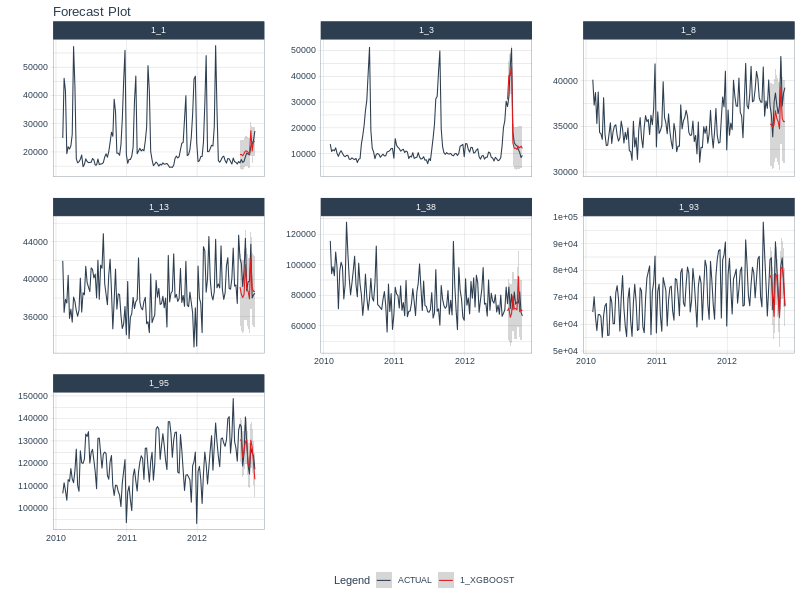

In [44]:
# Display the saved PNG plot in the notebook
forecast_test_plot = os.path.join(output_dir, "forecast_test_plot.png")
display(Image(filename=forecast_test_plot))

## Python

In [45]:
# Get predictions
fh = np.arange(1, int(X_test.shape[0] / unique_ids_train) + 1)
y_pred = fitted_model.predict(fh=fh, X=X_test)
print(f"Shape of predictions: {y_pred.shape}")

Shape of predictions: (84, 1)


In [46]:
# Compute global metrics
global_mae = mean_absolute_error(y_test, y_pred)
global_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
global_mape = mean_absolute_percentage_error(y_test, y_pred)
global_smape = mean_absolute_percentage_error(y_test, y_pred, symmetric=True)
global_mase = mean_absolute_scaled_error(y_test, y_pred, y_train=y_train)
global_r2 = r2_score(y_test, y_pred)

In [47]:
# Create global metrics DataFrame
global_metrics_df = pd.DataFrame({
    'MAE': [global_mae],
    'RMSE': [global_rmse],
    'MAPE': [global_mape * 100],
    'SMAPE': [global_smape * 100],
    'MASE': [global_mase],
    'R2': [global_r2]
})

print("Global Accuracy Metrics:")
display(global_metrics_df)

Global Accuracy Metrics:


,MAE,RMSE,MAPE,SMAPE,MASE,R2
0,4365.186545,6932.412364,11.334921,10.874245,0.742319,0.963402


In [48]:
# Initialize lists to store metrics per id
ids = y_test.index.get_level_values('id').unique()
local_metrics_list = []

# Verify that all DataFrames have the same multi-index
assert y_test.index.equals(y_pred.index), "y_test and y_pred indices do not match."

for id_ in ids:
    # Filter true and predicted values for the current id
    y_test_id = y_test.xs(id_, level='id')
    y_pred_id = y_pred.xs(id_, level='id')
    y_train_id = y_train.xs(id_, level='id')

    # Convert to numpy arrays
    y_true = y_test_id.values
    y_pred_id = y_pred_id.values
    y_train_id = y_train_id.values

    # Compute Metrics
    mae = mean_absolute_error(y_true, y_pred_id)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred_id))
    mape = mean_absolute_percentage_error(y_true, y_pred_id)
    smape = mean_absolute_percentage_error(y_true, y_pred_id, symmetric=True)
    mase = mean_absolute_scaled_error(y_true, y_pred_id, y_train=y_train_id)
    r2 = r2_score(y_true, y_pred_id)

    # Append to list
    local_metrics_list.append({
        'ID': id_,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape * 100,
        'SMAPE': smape * 100,
        'MASE': mase,
        'R2': r2
    })

# Create local metrics DataFrame
local_metrics_df = pd.DataFrame(local_metrics_list)
local_metrics_df.set_index('ID', inplace=True)

# Define a function to extract numerical parts from the ID
def extract_numeric_parts(id_str):
    try:
        parts = id_str.split('_')
        return tuple(int(part) for part in parts)
    except:
        # In case of unexpected format, return a high number to push it to the end
        return (float('inf'),)

# Create a temporary column for sorting
local_metrics_df['sort_key'] = local_metrics_df.index.map(extract_numeric_parts)

# Sort the DataFrame based on the sort_key
local_metrics_sorted = local_metrics_df.sort_values('sort_key')

# Drop the temporary sort_key column
local_metrics_sorted = local_metrics_sorted.drop('sort_key', axis=1)

# Replace the original DataFrame
local_metrics_df = local_metrics_sorted

print("Local Accuracy Metrics:")
display(local_metrics_df)

Local Accuracy Metrics:


,MAE,RMSE,MAPE,SMAPE,MASE,R2
ID,,,,,,
1_1,6543.591432,9142.348911,33.129023,27.465236,1.255566,-6.434617
1_3,5655.768053,9733.963979,20.709250,23.458825,2.444864,0.490102
1_8,1155.550169,1545.486713,3.043757,3.059595,0.581786,0.403809
1_13,1535.608711,1998.979818,3.782570,3.735017,0.644182,0.051731
1_38,8406.047214,10262.866269,11.080691,10.959365,0.668827,-2.279773
1_93,3577.939609,5278.014415,4.668358,4.525182,0.413625,0.620480
1_95,3681.800625,4302.032106,2.930798,2.916499,0.507943,0.705930


In [49]:
# Rename 'value' column
y_pred = y_pred.rename(columns={'value':'preds'})

# Combine actual and predicted values
y_test_pred = pd.concat([y_test, y_pred], axis=1)

In [50]:
# Extract unique 'id's
ids = y_test_pred.index.get_level_values('id').unique()
print(ids)

Index(['1_1', '1_3', '1_8', '1_13', '1_38', '1_93', '1_95'], dtype='object', name='id')


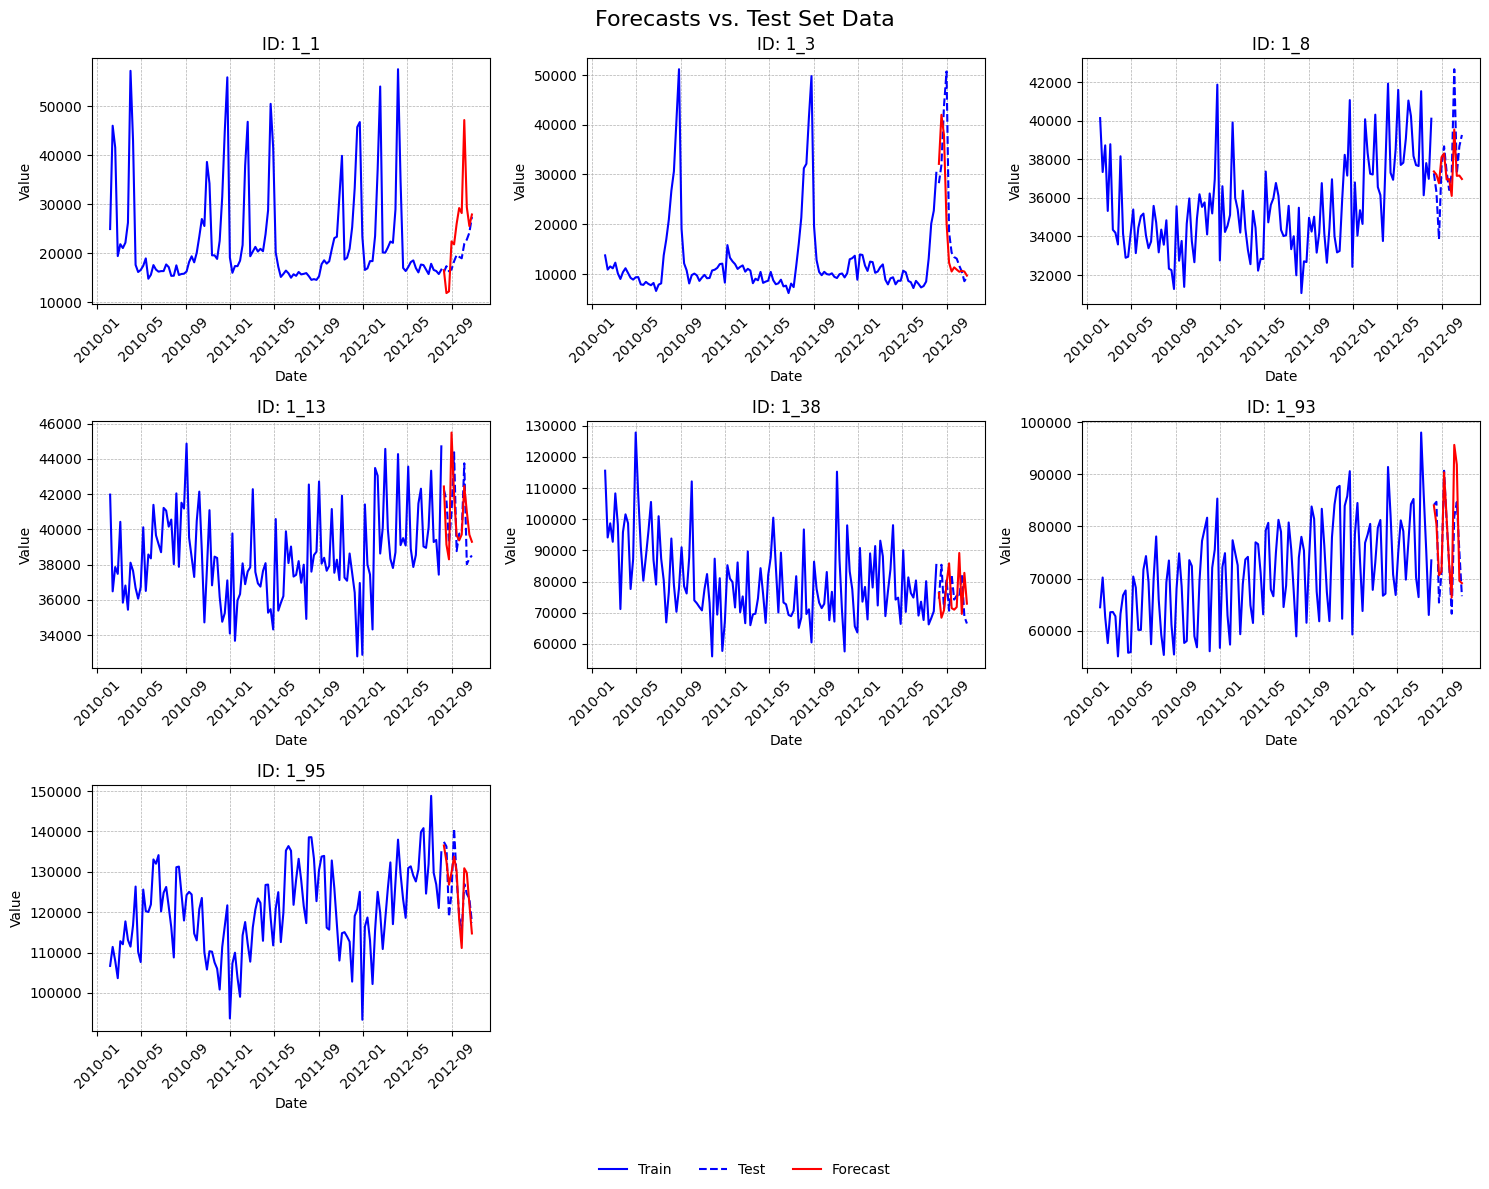

In [51]:
# Define plotting parameters
num_ids = len(ids)
cols = 3  # Number of subplots per row
rows = math.ceil(num_ids / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False, sharey=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Initialize lists to store legend handles and labels
handles = []
labels = []

for i, id_ in enumerate(ids):
    ax = axes[i]

    # Extract data for the current 'id'
    id_test = y_test_pred.loc[id_]
    id_train = y_train.loc[id_]

    # Plot training data
    line1, = ax.plot(
        id_train.index,
        id_train['value'],
        label='Train',
        color='blue'
    )

    # Plot test data
    line2, = ax.plot(
        id_test.index,
        id_test['value'],
        label='Test',
        color='blue',
        linestyle='--'
    )

    # Plot forecasts
    line3, = ax.plot(
        id_test.index,
        id_test['preds'],
        label='Forecast',
        color='red'
    )

    # Add gridlines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set title with 'id'
    ax.set_title(f"ID: {id_}")

    # Set labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)

    # Collect handles and labels from the first subplot for the global legend
    if i == 0:
        handles = [line1, line2, line3]
        labels = ['Train', 'Test', 'Forecast']

# Remove any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

# Add a title
fig.suptitle('Forecasts vs. Test Set Data', fontsize=16)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom

# Add a single legend at the bottom center
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)

# Display the plots
plt.show()

# Future Forecast

## R

In [52]:
# R script
r_code = """
# Refit the model
refit_table <- calibration_table %>%
    modeltime_refit(data = data_table)

# Make future data
future_table <- data_table %>%
    group_by(id) %>%
    future_frame(.length_out = 52, .bind_data = FALSE, .date_var = date)

print(future_table)

# Save the subsequent plot as a PNG file
png('/content/output_plots/forecast_future_plot.png', width=800, height=600)

# Forecast into the future
forecast_future <- refit_table %>%
    modeltime_forecast(
        new_data = future_table,
        actual_data = data_table,
        conf_by_id = TRUE
    ) %>%
    group_by(id) %>%
    plot_modeltime_forecast(
        .interactive = F,
        .facet_ncol = 2
    )

plot(forecast_future)

# Close the PNG device
dev.off()

# Return objects
list(future_table = future_table)
"""

In [53]:
# Run the R script
results = run_r_script(r_code)

# Extract the data returned from R
future_table_r = results[0]

# A tibble: 364 × 2
# Groups:   id [7]
   id    date      
   <fct> <date>    
 1 1_1   2012-11-02
 2 1_1   2012-11-09
 3 1_1   2012-11-16
 4 1_1   2012-11-23
 5 1_1   2012-11-30
 6 1_1   2012-12-07
 7 1_1   2012-12-14
 8 1_1   2012-12-21
 9 1_1   2012-12-28
10 1_1   2013-01-04
# ℹ 354 more rows
# ℹ Use `print(n = ...)` to see more rows


In [54]:
# Convert future data to DataFrame
future_table_df = pd.DataFrame(future_table_r)
future_table_df['date'] = pd.to_datetime(future_table_df['date'], unit='D', origin='1970-01-01')
print("Future Data:")
display(future_table_df.head(10))

Future Data:


,id,date
1,1_1,2012-11-02
2,1_1,2012-11-09
3,1_1,2012-11-16
4,1_1,2012-11-23
5,1_1,2012-11-30
6,1_1,2012-12-07
7,1_1,2012-12-14
8,1_1,2012-12-21
9,1_1,2012-12-28
10,1_1,2013-01-04


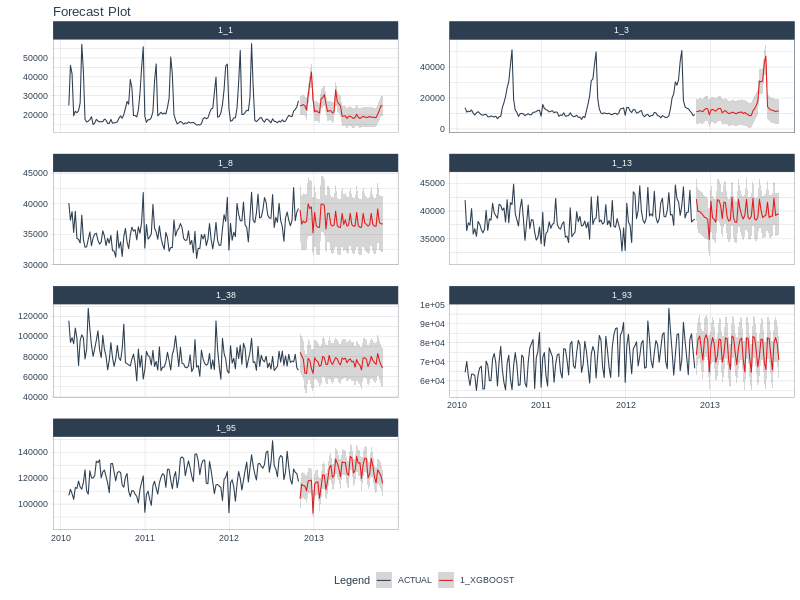

In [55]:
# Display the saved PNG plot in the notebook
forecast_future_plot = os.path.join(output_dir, "forecast_future_plot.png")
display(Image(filename=forecast_future_plot))

## Python

In [56]:
# Show all rows
pd.set_option('display.max_rows', None)

In [57]:
# Combine training and test sets
y_all = y_train.combine_first(y_test)
X_all = X_train.combine_first(X_test)

# Re-order the IDs
id_names = ['1_1', '1_3', '1_8', '1_13', '1_38', '1_93', '1_95']
y_all = y_all.reindex(id_names, axis=0, level=0)
X_all = X_all.reindex(id_names, axis=0, level=0)

In [58]:
# Check the indices
print("y_all Index:")
print(y_all.index)

print("\nX_all Index:")
print(X_all.index)

y_all Index:
MultiIndex([( '1_1', '2010-02-05'),
            ( '1_1', '2010-02-12'),
            ( '1_1', '2010-02-19'),
            ( '1_1', '2010-02-26'),
            ( '1_1', '2010-03-05'),
            ( '1_1', '2010-03-12'),
            ( '1_1', '2010-03-19'),
            ( '1_1', '2010-03-26'),
            ( '1_1', '2010-04-02'),
            ( '1_1', '2010-04-09'),
            ...
            ('1_95', '2012-08-24'),
            ('1_95', '2012-08-31'),
            ('1_95', '2012-09-07'),
            ('1_95', '2012-09-14'),
            ('1_95', '2012-09-21'),
            ('1_95', '2012-09-28'),
            ('1_95', '2012-10-05'),
            ('1_95', '2012-10-12'),
            ('1_95', '2012-10-19'),
            ('1_95', '2012-10-26')],
           names=['id', 'date'], length=1001)

X_all Index:
MultiIndex([( '1_1', '2010-02-05'),
            ( '1_1', '2010-02-12'),
            ( '1_1', '2010-02-19'),
            ( '1_1', '2010-02-26'),
            ( '1_1', '2010-03-05'),
          

In [59]:
# Reset index to access 'id' and 'date' as columns
y_all_reset = y_all.reset_index()

# Find the last date for each 'id'
last_dates = y_all_reset.groupby('id')['date'].max().reset_index()
last_dates.rename(columns={'date': 'last_date'}, inplace=True)

print("Last Dates per ID:")
display(last_dates)

Last Dates per ID:


,id,last_date
0,1_1,2012-10-26
1,1_13,2012-10-26
2,1_3,2012-10-26
3,1_38,2012-10-26
4,1_8,2012-10-26
5,1_93,2012-10-26
6,1_95,2012-10-26


In [60]:
# Initialize an empty list to store future dates DataFrames
future_dates_list = []

# Loop through each row in last_dates to generate future dates
for index, row in last_dates.iterrows():
    id_ = row['id']
    last_date = row['last_date']

    # Generate 52 future weekly dates starting from the next Friday after last_date
    future_dates = pd.date_range(start=last_date + pd.Timedelta(weeks=1), periods=52, freq='W-FRI')

    # Create a DataFrame for the current 'id' with future dates
    df_future = pd.DataFrame({
        'id': [id_] * len(future_dates),
        'date': future_dates
    })

    # Append the DataFrame to the list
    future_dates_list.append(df_future)

# Concatenate all future dates into a single DataFrame
future_dates_df = pd.concat(future_dates_list, ignore_index=True)

print("Future Dates DataFrame:")
display(future_dates_df.head(10))
print(f"\nShape of future dates DataFrame: {future_dates_df.shape}")

Future Dates DataFrame:


,id,date
0,1_1,2012-11-02
1,1_1,2012-11-09
2,1_1,2012-11-16
3,1_1,2012-11-23
4,1_1,2012-11-30
5,1_1,2012-12-07
6,1_1,2012-12-14
7,1_1,2012-12-21
8,1_1,2012-12-28
9,1_1,2013-01-04



Shape of future dates DataFrame: (364, 2)


In [61]:
# Create datetime features
future_dates_df = create_datetime_features(future_dates_df, 'date')

# Sort by 'id' and 'date' to ensure proper ordering
future_dates_df = future_dates_df.sort_values(['id', 'date'])

# Convert to pandas MultiIndex
future_dates_df.set_index(['id', 'date'], inplace=True)

# Re-index
future_dates_df = future_dates_df.reindex(id_names, axis=0, level=0)

# Filter for features to keep
future_dates_df = future_dates_df[features_to_keep.tolist()]

# Convert datetime features to categorical dtypes
categorical_features = ['year', 'month', 'day', 'week_of_year', 'quarter']

for col in categorical_features:
    future_dates_df[col] = future_dates_df[col].astype('category')

# Identify categorical columns
categorical_cols = future_dates_df.select_dtypes(include=['category', 'object']).columns.tolist()
print("Categorical Columns Identified for Encoding:", categorical_cols)

# One-hot encode categorical columns
future_dates_df = pd.get_dummies(future_dates_df, columns=categorical_cols, drop_first=False)

# Convert features to numeric
non_target_features = future_dates_df.columns

for col in non_target_features:
    future_dates_df[col] = future_dates_df[col].astype(int)

# For future_dates_df, add multiple columns at once
future_dates_df = pd.concat([
    future_dates_df,
    pd.DataFrame({
        'year_2010': 0,
        'year_2011': 0
    }, index=future_dates_df.index)
], axis=1)

# For X_all, add 'year_2013' at once
X_all = pd.concat([
    X_all,
    pd.DataFrame({
        'year_2013': 0
    }, index=X_all.index)
], axis=1)

# Verify columns match
assert set(future_dates_df.columns) == set(X_all.columns), "Columns in future data do not match X_all."

# Display future data
print("\nFuture Data:")
display(future_dates_df.head(10))

# Shape of future data
print("\nShape of Future Data:")
print(future_dates_df.shape)

# Shape of X_all
print("\nShape of X_all:")
print(X_all.shape)

Categorical Columns Identified for Encoding: ['year', 'month', 'day', 'week_of_year', 'quarter']

Future Data:


is_month_start  is_month_end  is_quarter_start  \
id  date                                                         
1_1 2012-11-02               0             0                 0   
    2012-11-09               0             0                 0   
    2012-11-16               0             0                 0   
    2012-11-23               0             0                 0   
    2012-11-30               0             1                 0   
    2012-12-07               0             0                 0   
    2012-12-14               0             0                 0   
    2012-12-21               0             0                 0   
    2012-12-28               0             0                 0   
    2013-01-04               0             0                 0   

                is_quarter_end  is_year_end  year_2012  year_2013  month_1  \
id  date                                                                     
1_1 2012-11-02               0            0          1          0        0   
    2012-11-09               0            0          1          0        0   
    2012-11-16               0            0          1          0        0   
    2012-11-23               0            0          1          0        0   
    2012-11-30               0            0          1          0        0   
    2012-12-07               0            0          1          0        0   
    2012-12-14               0            0          1          0        0   
    2012-12-21               0            0          1          0        0   
    2012-12-28               0            0          1          0        0   
    2013-01-04               0            0          0          1        1   

                month_2  month_3  ...  week_of_year_49  week_of_year_50  \
id  date                          ...                                     
1_1 2012-11-02        0        0  ...                0                0   
    2012-11-09        0        0  ...                0                0   
    2012-11-16        0        0  ...                0                0   
    2012-11-23        0        0  ...                0                0   
    2012-11-30        0        0  ...                0                0   
    2012-12-07        0        0  ...                1                0   
    2012-12-14        0        0  ...                0                1   
    2012-12-21        0        0  ...                0                0   
    2012-12-28        0        0  ...                0                0   
    2013-01-04        0        0  ...                0                0   

                week_of_year_51  week_of_year_52  quarter_1  quarter_2  \
id  date                                                                 
1_1 2012-11-02                0                0          0          0   
    2012-11-09                0                0          0          0   
    2012-11-16                0                0          0          0   
    2012-11-23                0                0          0          0   
    2012-11-30                0                0          0          0   
    2012-12-07                0                0          0          0   
    2012-12-14                0                0          0          0   
    2012-12-21                1                0          0          0   
    2012-12-28                0                1          0          0   
    2013-01-04                0                0          1          0   

                quarter_3  quarter_4  year_2010  year_2011  
id  date                                                    
1_1 2012-11-02          0          1          0          0  
    2012-11-09          0          1          0          0  
    2012-11-16          0          1          0          0  
    2012-11-23          0          1          0          0  
    2012-11-30          0          1          0          0  
    2012-12-07          0          1          0          0  
    2012


Shape of Future Data:
(364, 108)

Shape of X_all:
(1001, 108)


In [62]:
# Refit the model
refitted_model = forecaster.fit(y_all, X_all)

In [63]:
# Get predictions
fh = np.arange(1, 53)
y_future = refitted_model.predict(fh=fh, X=future_dates_df)
print(f"Shape of future predictions: {y_future.shape}")

Shape of future predictions: (364, 1)


In [64]:
# Extract unique 'id's
ids = y_future.index.get_level_values('id').unique()
print(ids)

Index(['1_1', '1_3', '1_8', '1_13', '1_38', '1_93', '1_95'], dtype='object', name='id')


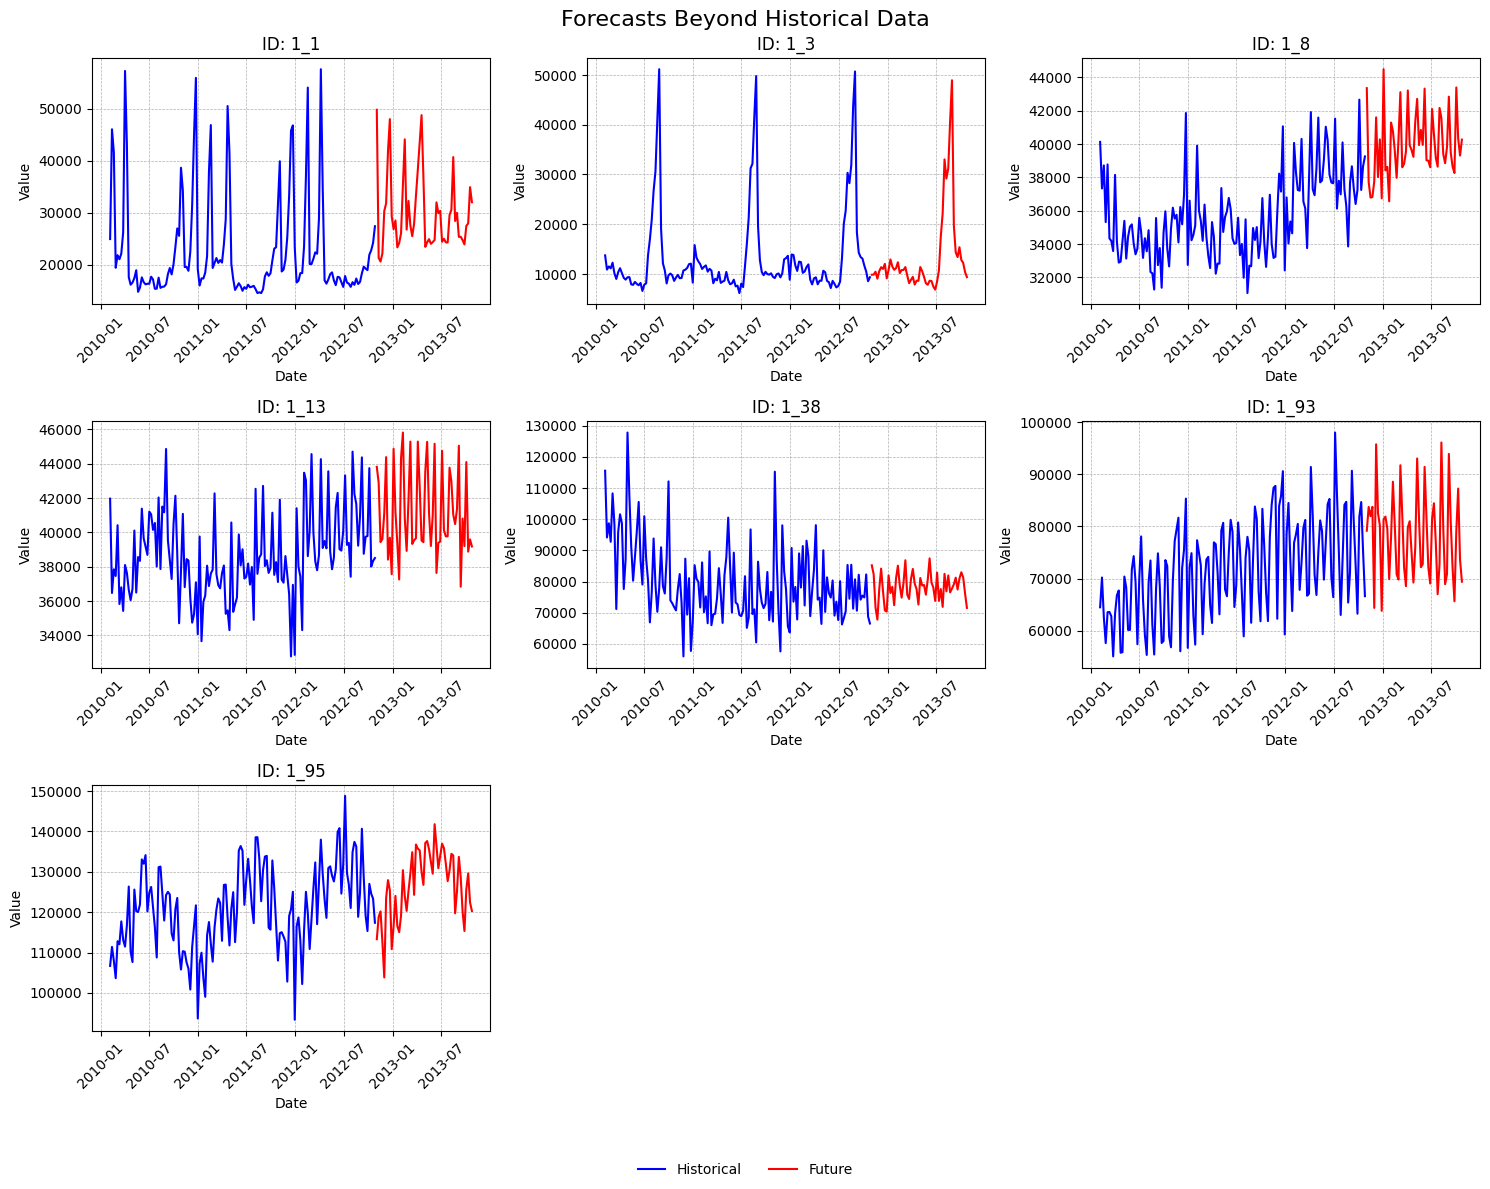

In [65]:
# Define plotting parameters
num_ids = len(ids)
cols = 3  # Number of subplots per row
rows = math.ceil(num_ids / cols)

# Create subplots
fig, axes = plt.subplots(rows, cols, figsize=(cols * 5, rows * 4), sharex=False, sharey=False)

# Flatten the axes array for easy iteration
axes = axes.flatten()

# Initialize lists to store legend handles and labels
handles = []
labels = []

for i, id_ in enumerate(ids):
    ax = axes[i]

    # Extract data for the current 'id'
    id_hist = y_all.loc[id_]
    id_future = y_future.loc[id_]

    # Plot historical data
    line1, = ax.plot(
        id_hist.index,
        id_hist['value'],
        label='Historical',
        color='blue'
    )

    # Plot future data
    line2, = ax.plot(
        id_future.index,
        id_future['value'],
        label='Future',
        color='red'
    )

    # Add gridlines
    ax.grid(True, which='both', linestyle='--', linewidth=0.5)

    # Set title with 'id'
    ax.set_title(f"ID: {id_}")

    # Set labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Value')

    # Rotate x-axis labels
    plt.setp(ax.get_xticklabels(), rotation=45)

    # Collect handles and labels from the first subplot for the global legend
    if i == 0:
        handles = [line1, line2]
        labels = ['Historical', 'Future']

# Remove any unused subplots
for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j])

# Add a title
fig.suptitle('Forecasts Beyond Historical Data', fontsize=16)

# Adjust layout to make space for the legend
plt.tight_layout(rect=[0, 0.05, 1, 1])  # Leave space at the bottom

# Add a single legend at the bottom center
fig.legend(handles, labels, loc='lower center', ncol=3, frameon=False)

# Display the plots
plt.show()